# Keras versus Poisonous Mushrooms

This example demonstrates building a simple dense neural network using Keras.  The example uses [Agaricus Lepiota](https://archive.ics.uci.edu/ml/datasets/Mushroom) training data to detect poisonous mushrooms.

In [1]:
from pandas import read_csv
srooms_df = read_csv('../data/agaricus-lepiota.data.csv')
srooms_df.head()

,edibility,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


## Feature extraction

If we wanted to use all the features in the training set then we would need to map each out.  The ```LabelEncoder``` converts T/F data to 1 and 0.  The ```LabelBinarizer``` converts categorical data to **one hot encoding**. 


If we wanted to use all the features in the training set then we would need to map each out:

```
column_names = srooms_df.axes[1]
def get_mapping(name):
    if(name == 'edibility' or name == 'gill-attachment'):
        return (name, sklearn.preprocessing.LabelEncoder())
    else:
        return (name, sklearn.preprocessing.LabelBinarizer())
    
mappings = list(map(lambda name: get_mapping(name), column_names)
```

We will use a subset of features to make it interesting.  Are there simple rules or a handful of features that can be used to test edibility?  Lets try a few.

In [2]:
from sklearn_pandas import DataFrameMapper
import sklearn
import numpy as np

mappings = ([
    ('edibility', sklearn.preprocessing.LabelEncoder()),
    ('odor', sklearn.preprocessing.LabelBinarizer()),
    ('habitat', sklearn.preprocessing.LabelBinarizer()),
    ('spore-print-color', sklearn.preprocessing.LabelBinarizer())
])

In [3]:
mapper = DataFrameMapper(mappings)
srooms_np = mapper.fit_transform(srooms_df.copy())

Now lets transform the textual data to a vector...

The transformed data should have 26 features. The break down is as follows:
* Edibility (0 = edible, 1 = poisonous)
* odor (9 features): 
    ```[almond=a, creosote=c, foul=f, anise=l, musty=m, none=n, pungent=p, spicy=s, fishy=y]```
* habitat (7 features):
    ```[woods=d, grasses=g, leaves=l, meadows=m, paths=p, urban=u, waste=w]```
* spore-print-color (9 features):
    ```[buff=b, chocolate=h, black=k, brown=n, orange=o, green=r, purple=u, white=w, yellow=y]```

In [4]:
print(srooms_np.shape)
print("Frist sample: {}".format(srooms_np[0]))
print("  edibility (poisonous): {}".format(srooms_np[0][0]))
print("  ordr (pungent): {}".format(srooms_np[0][1:10]))
print("  habitat (urban): {}".format(srooms_np[0][10:17]))
print("  spore-print-color (black): {}".format(srooms_np[0][17:]))

(8124, 26)
Frist sample: [1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0]
  edibility (poisonous): 1
  ordr (pungent): [0 0 0 0 0 0 1 0 0]
  habitat (urban): [0 0 0 0 0 1 0]
  spore-print-color (black): [0 0 1 0 0 0 0 0 0]


Before we train the neural network, let's split the data into training and test datasets.

In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(srooms_np, test_size = 0.2, random_state=7)
train_labels = train[:,0:1]
train_data = train[:,1:]
test_labels = test[:,0:1]
test_data = test[:,1:]
print('training data dims: {}, label dims: {}'.format(train_data.shape,train_labels.shape))
print('test data dims: {}, label dims: {}'.format(test_data.shape,test_labels.shape))

training data dims: (6499, 25), label dims: (6499, 1)
test data dims: (1625, 25), label dims: (1625, 1)


# Model Definition

We will create a simple three layer neural network.  The network contains two dense layers and a dropout layer (to avoid overfitting).  

## Layer 1: Dense Layer

A dense layer applies an activation function to the output of $W \cdot x + b$.  If the dense layer only had three inputs and outputs, then the dense layer looks like this... 

![Dense Layer](images/DenseLayer.png)

Under the covers, keras represents the layer's weights as a matrix.  The inputs, outputs, and biases are vectors...

$$ 
\begin{bmatrix} 
y_1 \\
y_2 \\
y_3
\end{bmatrix}
=
relu
\begin{pmatrix}
\begin{bmatrix} 
W_{1,1} & W_{1,2} &  W_{1,3} \\
W_{2,1} & W_{2,2} &  W_{2,3} \\
W_{3,1} & W_{3,2} &  W_{3,3}
\end{bmatrix}
\cdot
\begin{bmatrix} 
x_1 \\
x_2 \\
x_3
\end{bmatrix}
+
\begin{bmatrix} 
b_1 \\
b_2 \\
b_3
\end{bmatrix}
\end{pmatrix}
$$

If this operation was decomposed futher, it would look like this...

$$ 
\begin{bmatrix} 
y_1 \\
y_2 \\
y_3
\end{bmatrix}
=
\begin{bmatrix}
relu(W_{1,1} x_1 + W_{1,2} x_2 +  W_{1,3} x_3 + b_1) \\
relu(W_{2,1} x_1 + W_{2,2} x_2 +  W_{2,3} x_3 + b_2) \\
relu(W_{3,1} x_1 + W_{3,2} x_2 +  W_{3,3} x_3 + b_3)
\end{bmatrix}
$$

The Rectified Linear Unit (RELU) function looks like this...

![RELU](images/relu.png)

## Layer 2: Dropout

The dropout layer prevents overfitting by randomly dropping inputs to the next layer.

![dropout layer](./images/dropout.png)

## Layer 3: Dense Layer

This layer acts like the first one, except this layer applies a sigmod activation function.  The output is the probability a mushroom is poisonous.  If a sample represents a small probability of poisoning, we'll want to know!

![sigmod](./images/sigmod.png)

$$y = sigmod(W \cdot x + b)$$

## Putting It Together

Fortunately, we don't need to worry about defining the parameters (the weigths and biases) in Keras.  We just define the layers in a sequence...

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(20, activation='relu', input_dim=25))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                520       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________


#  Model Training

## Model Complie

This step configures the model for training with the following settings:
* An optimizier (update the gradients based on a loss function)
* A loss function
* Metrics to track during training 

In [7]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Keras Callbacks

Keras provides callbacks as a means to instrument internal state.  In this example, we will write a tensorflow event log.  The event log enables a tensorboard visualization of the translated model.  The event log also captures key metrics during training. 

> Note: This step is completely optional and depends on the backend engine.  

In [8]:
from keras.callbacks import TensorBoard
tensor_board = TensorBoard(log_dir='./logs/keras_srooms', histogram_freq=1)

In [9]:
model.fit(train_data, train_labels, epochs=10, batch_size=32, callbacks=[tensor_board])

INFO:tensorflow:Summary name dense_1/kernel:0 is illegal; using dense_1/kernel_0 instead.
INFO:tensorflow:Summary name dense_1/bias:0 is illegal; using dense_1/bias_0 instead.
INFO:tensorflow:Summary name dense_2/kernel:0 is illegal; using dense_2/kernel_0 instead.
INFO:tensorflow:Summary name dense_2/bias:0 is illegal; using dense_2/bias_0 instead.
Epoch 1/10
6499/6499 [==============================] - 0s - loss: 0.4709 - acc: 0.8120     
Epoch 2/10
6499/6499 [==============================] - 0s - loss: 0.2020 - acc: 0.9508     
Epoch 3/10
6499/6499 [==============================] - 0s - loss: 0.1118 - acc: 0.9729     
Epoch 4/10
6499/6499 [==============================] - 0s - loss: 0.0759 - acc: 0.9818     
Epoch 5/10
6499/6499 [==============================] - 0s - loss: 0.0596 - acc: 0.9865     
Epoch 6/10
6499/6499 [==============================] - 0s - loss: 0.0447 - acc: 0.9885     
Epoch 7/10
6499/6499 [==============================] - 0s - loss: 0.0397 - acc: 0.9900   

# Model Evaluation

In [10]:
score = model.evaluate(test_data, test_labels, batch_size=1625)
print(score)

1625/1625 [==============================] - 0s
[0.010582135990262032, 0.99507689476013184]


# Save/Restore the Model

Keras provides methods to save the models architecture as yaml or json.  

In [11]:
print(model.to_yaml())
definition = model.to_yaml()

backend: tensorflow
class_name: Sequential
config:
- class_name: Dense
  config:
    activation: relu
    activity_regularizer: null
    batch_input_shape: !!python/tuple [null, 25]
    bias_constraint: null
    bias_initializer:
      class_name: Zeros
      config: {}
    bias_regularizer: null
    dtype: float32
    kernel_constraint: null
    kernel_initializer:
      class_name: VarianceScaling
      config: {distribution: uniform, mode: fan_avg, scale: 1.0, seed: null}
    kernel_regularizer: null
    name: dense_1
    trainable: true
    units: 20
    use_bias: true
- class_name: Dropout
  config: {name: dropout_1, rate: 0.5, trainable: true}
- class_name: Dense
  config:
    activation: sigmoid
    activity_regularizer: null
    bias_constraint: null
    bias_initializer:
      class_name: Zeros
      config: {}
    bias_regularizer: null
    kernel_constraint: null
    kernel_initializer:
      class_name: VarianceScaling
      config: {distribution: uniform, mode: fan_avg, sc

We also need to save the *parameters* or weights learns from training.

In [12]:
model.save_weights('/tmp/srmooms.hdf5')

## Model Restore

We'll load the definition and parameters...

In [13]:
from keras.models import model_from_yaml
new_model = model_from_yaml(definition)
new_model.load_weights('/tmp/srmooms.hdf5')

Lets run some predictions on the newly initiated model.

In [14]:
predictions = new_model.predict(test_data[0:25]).round()
for i in range(25):
    if predictions[i]:
        print('Test sample {} is poisonous.'.format(i))

Test sample 0 is poisonous.
Test sample 1 is poisonous.
Test sample 8 is poisonous.
Test sample 11 is poisonous.
Test sample 14 is poisonous.
Test sample 15 is poisonous.
Test sample 17 is poisonous.


# Confusion Matrix

In [15]:
predictions = new_model.predict(test_data).round()
labels = test_labels[:,0]

In [16]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels,predictions)

In [17]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[840   0]
 [  8 777]]


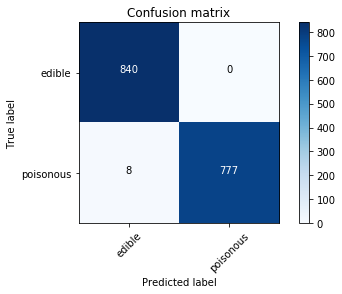

In [18]:
plot_confusion_matrix(cm,['edible','poisonous'])
plt.show()